# Обучение без учителя. Ассоциативные правила

## Импорты

In [125]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules, fpgrowth
import matplotlib.pyplot as plt
import networkx as nx
import kagglehub
import os
import seaborn as sns


## Теория

**Обучение без учителя** работает путем анализа немаркированных данных для выявления закономерностей и взаимосвязей. Данные не помечены никакими предопределенными категориями или результатами, поэтому алгоритм должен находить эти закономерности и взаимосвязи самостоятельно.

Ассоциативные правила (или ассоциативные правила выявления зависимостей) — это метод машинного обучения, используемый для поиска скрытых взаимосвязей между элементами в больших наборах данных. Этот метод часто применяется в задачах анализа корзины покупок, когда цель — выявить, какие товары покупаются вместе.  

**Основные концепции:**  
1. Поддержка (Support) — процент транзакций, в которых встречаются оба элемента правила. 
Например, если 30% покупателей купили молоко и хлеб, то поддержка этого набора — 30%.  

2. Достоверность (Confidence) — вероятность того, что если покупатель приобрёл один товар, то он купит и другой.  
Например, если 70% людей, купивших молоко, также покупают хлеб, то достоверность правила «молоко → хлеб» равна 70%.  

3. Подъем (Lift) — показатель, который сравнивает, насколько часто два товара встречаются вместе, по сравнению с тем, если бы они были независимы.  
Подъем больше 1 говорит о том, что товары связаны положительно.  

**Пример:**  
Правило «молоко → хлеб» с поддержкой 20% и достоверностью 70% означает, что 20% всех транзакций включают оба товара, и 70% из тех, кто купил молоко, также купили хлеб.  

## Цель работы

Исследование методов анализа ассоциативных правил.

## Постановка задачи

Загрузить датасет в соответствии с вариантом задания. Данные представлены в виде csv таблицы. Данные представляют собой информацию о купленных вместе товарах.

1. Запустить представленный во вложении файл.   
Предварительно установите необходимые библиотеки и скачайте датасет. В отчете приведите описание датасета.
2. Выполните анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания.  
Проанализируйте полученные результаты: выделите полезные и тривиальные правила; оцените значение достоверности, лифта правил; оцените влияние параметров на получаемые правила.
3. Проведите анализ правил, используя алгоритм FPG.  
Какие правила получились в результате использования данного алгоритма?
4. Определите минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.
5. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получите наборы ассоциативных правил.  
Сделайте выводы для проведенных экспериментов.
6. Для анализа правил был построен граф.  
Проанализируйте полученный граф, какую информацию можно из него извлечь?
7. Предложите и реализуйте свой способ визуализации полученных правил.

## Датасет

https://www.kaggle.com/datasets/cyberphile/ott-tvshows  
Начальные параметры для обоих алгоритмов:  
* поддержка 0.02  
* достоверность 0.3 

### Описание датасета

Датасет представляет из себя транзакции с покупками сериалов на площадке  
Каждя отдельная строка - транзакция, покупки в строке расположены в хронолгическом порядке

In [3]:
data_path = kagglehub.dataset_download("cyberphile/ott-tvshows")


In [4]:
data = pd.read_csv(os.path.join(data_path, 'TV_shows.csv'), header=None)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9690 entries, 0 to 9689
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       9690 non-null   object
 1   1       7557 non-null   object
 2   2       5947 non-null   object
 3   3       4667 non-null   object
 4   4       3678 non-null   object
 5   5       2837 non-null   object
 6   6       2197 non-null   object
 7   7       1664 non-null   object
 8   8       1231 non-null   object
 9   9       887 non-null    object
 10  10      644 non-null    object
 11  11      464 non-null    object
 12  12      348 non-null    object
 13  13      272 non-null    object
 14  14      196 non-null    object
 15  15      141 non-null    object
 16  16      95 non-null     object
 17  17      66 non-null     object
 18  18      52 non-null     object
 19  19      38 non-null     object
 20  20      29 non-null     object
 21  21      18 non-null     object
 22  22      14 non-null     

In [6]:
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,Cobra Kai,Lupin,12 Monkeys,Sherlock,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lost,Jack Ryan,The Flash,Game of thrones,House of Cards,12 Monkeys,Vikings,Fringe,The Mentalist,The Alienist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,9690,7557,5947,4667,3678,2837,2197,1664,1231,887,...,14,8,7,7,6,5,4,1,1,1
unique,156,145,147,145,142,130,132,133,122,115,...,13,7,6,7,5,4,3,1,1,1
top,Daredevil,Sex Education,Sex Education,Sex Education,Two and a half men,Outer Banks,Outer Banks,Lucifer,Outer Banks,Lucifer,...,Spartacus,Dark,Shadow and Bone,The Queen's Gambit,Big Little Lies,Chernobyl,Startup,You,Big Little Lies,Dark
freq,811,646,499,310,174,149,120,74,60,48,...,2,2,2,1,2,2,2,1,1,1


# Анализ датасета

### Самый востребованный товар 

In [8]:
transaction = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        transaction.append(data.values[i,j])

transaction = np.array(transaction)

df = pd.DataFrame(transaction, columns=["items"]) 
df["incident_count"] = 1

indexNames = df[df['items'] == "nan" ].index
df.drop(indexNames , inplace=True)

df_table = df.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()

df_table.head(10)

,items,incident_count
0,Sex Education,2477
1,Ozark,1877
2,Two and a half men,1779
3,Outer Banks,1696
4,Atypical,1356
5,Stranger Things,1070
6,Mr. Robot,1060
7,The Blacklist,1016
8,Lucifer,949
9,Daredevil,910


### Самый частый первый выбор

In [9]:
transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,0])

transaction = np.array(transaction)

df_first = pd.DataFrame(transaction, columns=["items"])
df_first["incident_count"] = 1

indexNames = df_first[df_first['items'] == "nan" ].index
df_first.drop(indexNames , inplace=True)

df_table_first = df_first.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_first["tvshow"] = "tvshow"
df_table_first = df_table_first.truncate(before=-1, after=10)

In [14]:
fig = go.Figure(data=[go.Bar(x=df_table_first["items"], y=df_table_first["incident_count"],
            hovertext=df_table_first["items"], text=df_table_first["incident_count"], textposition="outside")])

fig.update_layout(title_text="Первый выбор покупателей")
fig.show()

## Препроцессинг

Преобразуем набор данных в матрицу 1 - 0, где:  
* строки - это транзакции
* столбцы - товары   
* 1 - если продукт был куплен в данной транзакции  
* 0 - если продукт не был куплен в данной транзакции.

In [77]:
transaction = []
for i in range(data.shape[0]):
    value = [str(data.values[i,j]) for j in range(data.shape[1])]
    cleaned_data = list(filter(lambda x: x != 'nan', value))
    transaction.append(cleaned_data)
    
transaction

[['Cobra Kai', 'Lupin', '12 Monkeys', 'Sherlock'],
 ['Lost',
  'Jack Ryan',
  'The Flash',
  'Game of thrones',
  'House of Cards',
  '12 Monkeys',
  'Vikings',
  'Fringe',
  'The Mentalist',
  'The Alienist',
  'Big Little Lies',
  'Chernobyl'],
 ['Sex Education', 'Dr. House', 'Kingdom', 'The Walking Dead'],
 ['Ozark', 'Sex Education', 'Constantine', 'Preacher', 'Vikings', 'The Tick'],
 ['Naruto'],
 ['Sex Education'],
 ['Locke & Key'],
 ['Lupin'],
 ['Fringe', 'Shooter', 'How to get away with murder'],
 ['Queen of the South', 'Better Call Saul', 'Peaky Blinders'],
 ['Sex Education'],
 ['Atypical', 'Stranger Things', 'Homeland', 'Brooklyn Nine Nine'],
 ['Daredevil', 'Atypical', 'The Walking Dead', 'The Witcher'],
 ['One Piece', 'Queen of the South'],
 ['Demon Slayer',
  'Atypical',
  'Stranger Things',
  'Absentia',
  'The Alienist',
  'Chernobyl'],
 ['Queen of the South',
  'The Blacklist',
  'Succession',
  'Sex Education',
  'Berlin Station',
  'Atypical',
  'Two and a half men',
  '

In [79]:
te = TransactionEncoder()
te_ary = te.fit_transform(transaction)
dataset = pd.DataFrame(te_ary, columns=te.columns_)
dataset = dataset.dropna(how='any',axis=1)
dataset.head(2)

,12 Monkeys,24,Absentia,Alice in Borderland,Altered Carbon,American Gods,Another Life,Archer,Arrow,Atypical,...,True Detective,Two and a half men,Upload,Vikings,Watchmen,Westworld,White Collar,X-Files,You,Young Sheldon
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [80]:
print(f'Количество транзакций:{dataset.shape[1]}\nКоличество товаров:{dataset.shape[0]}')

Количество транзакций:156
Количество товаров:9690


In [88]:
dataset.columns

Index(['12 Monkeys', '24', 'Absentia', 'Alice in Borderland', 'Altered Carbon',
       'American Gods', 'Another Life', 'Archer', 'Arrow', 'Atypical',
       ...
       'True Detective', 'Two and a half men', 'Upload', 'Vikings', 'Watchmen',
       'Westworld', 'White Collar', 'X-Files', 'You', 'Young Sheldon'],
      dtype='object', length=156)

In [89]:
dataset_int = dataset.map(lambda x: 1 if x == True else 0)
dataset_int.head(2)

,12 Monkeys,24,Absentia,Alice in Borderland,Altered Carbon,American Gods,Another Life,Archer,Arrow,Atypical,...,True Detective,Two and a half men,Upload,Vikings,Watchmen,Westworld,White Collar,X-Files,You,Young Sheldon
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Применение ассоциативных правил методом Apriori

### Использование параметров в соответствии с вариантами

In [117]:
frequent_itemsets = apriori(dataset, min_support=0.02, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.058617,(12 Monkeys),1
1,0.077090,(Absentia),1
2,0.024768,(Alice in Borderland),1
3,0.057792,(Archer),1
4,0.026109,(Arrow),1
...,...,...,...
120,0.024045,"(Two and a half men, Stranger Things)",2
121,0.024665,"(The Blacklist, Two and a half men)",2
122,0.021053,"(Two and a half men, The Walking Dead)",2
123,0.022394,"(Atypical, Ozark, Sex Education)",3


In [118]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.3)
rules = rules[rules['antecedents'].apply(lambda x: len(x)) > 0]
rules = rules[rules['consequents'].apply(lambda x: len(x)) > 0]

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
136,"(Ozark, Sex Education)",(Mr. Robot),0.075129,0.109391,0.023117,0.307692,2.812772,0.014898,1.286435,0.696831,2,1
137,(Mr. Robot),"(Ozark, Sex Education)",0.109391,0.075129,0.023117,0.211321,2.812772,0.014898,1.172683,0.723638,1,2
46,(The Blacklist),(Demon Slayer),0.104850,0.075439,0.020640,0.196850,2.609412,0.012730,1.151170,0.689015,1,1
47,(Demon Slayer),(The Blacklist),0.075439,0.104850,0.020640,0.273598,2.609412,0.012730,1.232306,0.667097,1,1
138,(Ozark),"(Mr. Robot, Sex Education)",0.193705,0.048916,0.023117,0.119339,2.439659,0.013641,1.079966,0.731874,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
83,(Ozark),(Outer Banks),0.193705,0.175026,0.033024,0.170485,0.974055,-0.000880,0.994526,-0.031978,1,1
68,(Lucifer),(Sex Education),0.097936,0.255624,0.024355,0.248683,0.972845,-0.000680,0.990761,-0.030015,1,1
69,(Sex Education),(Lucifer),0.255624,0.097936,0.024355,0.095277,0.972845,-0.000680,0.997060,-0.036143,1,1
84,(Outer Banks),(Sex Education),0.175026,0.255624,0.040144,0.229363,0.897267,-0.004596,0.965923,-0.121873,1,1


#### Анализ получившихся правил

In [119]:
print(f'Количество правил {len(rules)}\nКоличество тривиальных правил {len(rules[np.abs(rules['lift'] - 1) < 0.05])}\nКоличество полезных правил {len(rules[rules['lift'] > 1.2])}')

Количество правил 140
Количество тривиальных правил 6
Количество полезных правил 122


##### Тривиальные правила

In [120]:
rules[np.abs(rules['lift'] - 1) < 0.05]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
38,(Dark),(Sex Education),0.089164,0.255624,0.023220,0.260417,1.018747,0.000427,1.006480,0.020204,1,1
39,(Sex Education),(Dark),0.255624,0.089164,0.023220,0.090836,1.018747,0.000427,1.001839,0.024722,1,1
68,(Lucifer),(Sex Education),0.097936,0.255624,0.024355,0.248683,0.972845,-0.000680,0.990761,-0.030015,1,1
69,(Sex Education),(Lucifer),0.255624,0.097936,0.024355,0.095277,0.972845,-0.000680,0.997060,-0.036143,1,1
82,(Outer Banks),(Ozark),0.175026,0.193705,0.033024,0.188679,0.974055,-0.000880,0.993806,-0.031277,1,1
83,(Ozark),(Outer Banks),0.193705,0.175026,0.033024,0.170485,0.974055,-0.000880,0.994526,-0.031978,1,1


##### Полезные правила

In [121]:
rules[rules['lift'] > 1.2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(12 Monkeys),(Sex Education),0.058617,0.255624,0.024252,0.413732,1.618517,0.009268,1.269686,0.405946,1,1
1,(Sex Education),(12 Monkeys),0.255624,0.058617,0.024252,0.094873,1.618517,0.009268,1.040056,0.513384,1,1
2,(Atypical),(Cobra Kai),0.139938,0.083075,0.021569,0.154130,1.855301,0.009943,1.084002,0.536013,1,1
3,(Cobra Kai),(Atypical),0.083075,0.139938,0.021569,0.259627,1.855301,0.009943,1.161661,0.502772,1,1
4,(Family Guy),(Atypical),0.071517,0.139938,0.020743,0.290043,2.072654,0.010735,1.211429,0.557390,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
135,"(Mr. Robot, Sex Education)",(Ozark),0.048916,0.193705,0.023117,0.472574,2.439659,0.013641,1.528736,0.620457,2,1
136,"(Ozark, Sex Education)",(Mr. Robot),0.075129,0.109391,0.023117,0.307692,2.812772,0.014898,1.286435,0.696831,2,1
137,(Mr. Robot),"(Ozark, Sex Education)",0.109391,0.075129,0.023117,0.211321,2.812772,0.014898,1.172683,0.723638,1,2
138,(Ozark),"(Mr. Robot, Sex Education)",0.193705,0.048916,0.023117,0.119339,2.439659,0.013641,1.079966,0.731874,1,2


#### Статистика по правилам

In [122]:
print(rules[['support', 'confidence', 'lift']].describe())

          support  confidence        lift
count  140.000000  140.000000  140.000000
mean     0.028770    0.234458    1.609984
std      0.010020    0.114569    0.389567
min      0.020124    0.079935    0.897267
25%      0.022394    0.133024    1.304146
50%      0.025181    0.218548    1.566034
75%      0.030650    0.314458    1.854385
max      0.075129    0.511792    2.812772


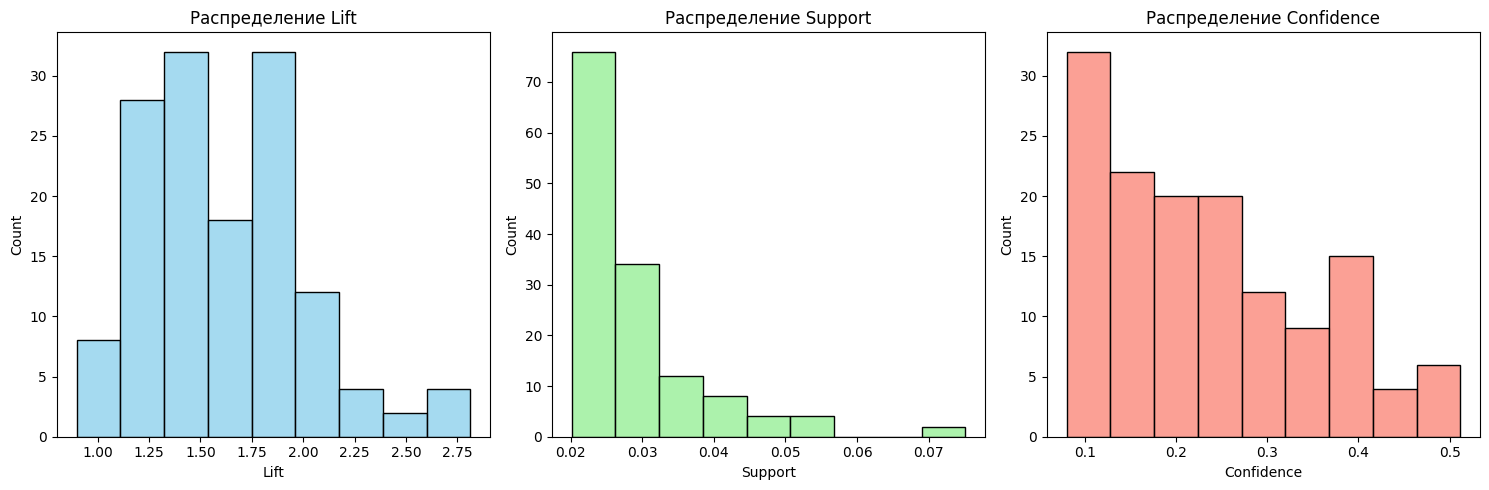

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rules['lift'], bins='sturges', color='skyblue')
plt.title('Распределение Lift')
plt.xlabel('Lift')

plt.subplot(1, 3, 2)
sns.histplot(rules['support'], bins='sturges', color='lightgreen')
plt.title('Распределение Support')
plt.xlabel('Support')

plt.subplot(1, 3, 3)
sns.histplot(rules['confidence'], bins='sturges', color='salmon')
plt.title('Распределение Confidence')
plt.xlabel('Confidence')

plt.tight_layout()
plt.show()


In [144]:
filtered_rules = rules[rules['lift'] > 1.8]


C:\Users\user\AppData\Local\Temp\ipykernel_2888\3525403928.py:10: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



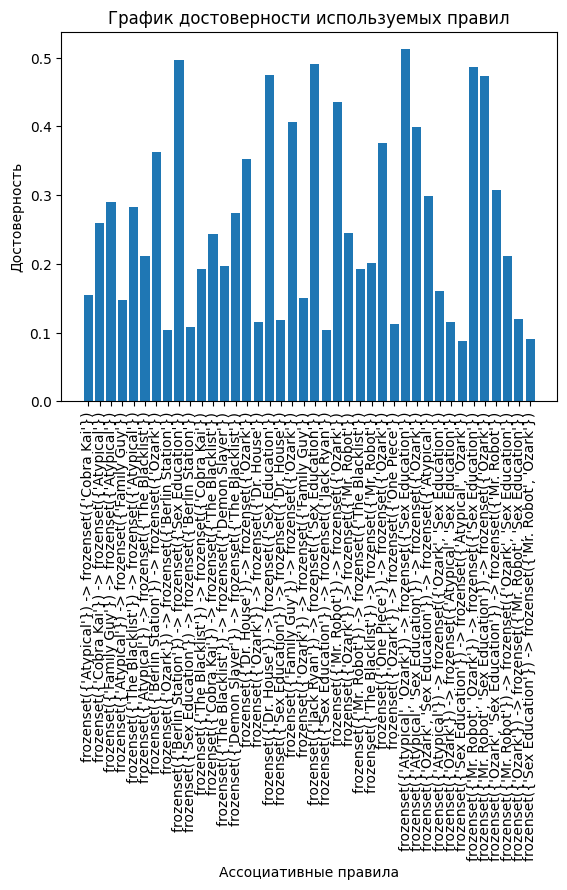

In [ ]:

products_1 = filtered_rules["antecedents"].tolist()
products_2 = filtered_rules["consequents"].tolist()
confidence = filtered_rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

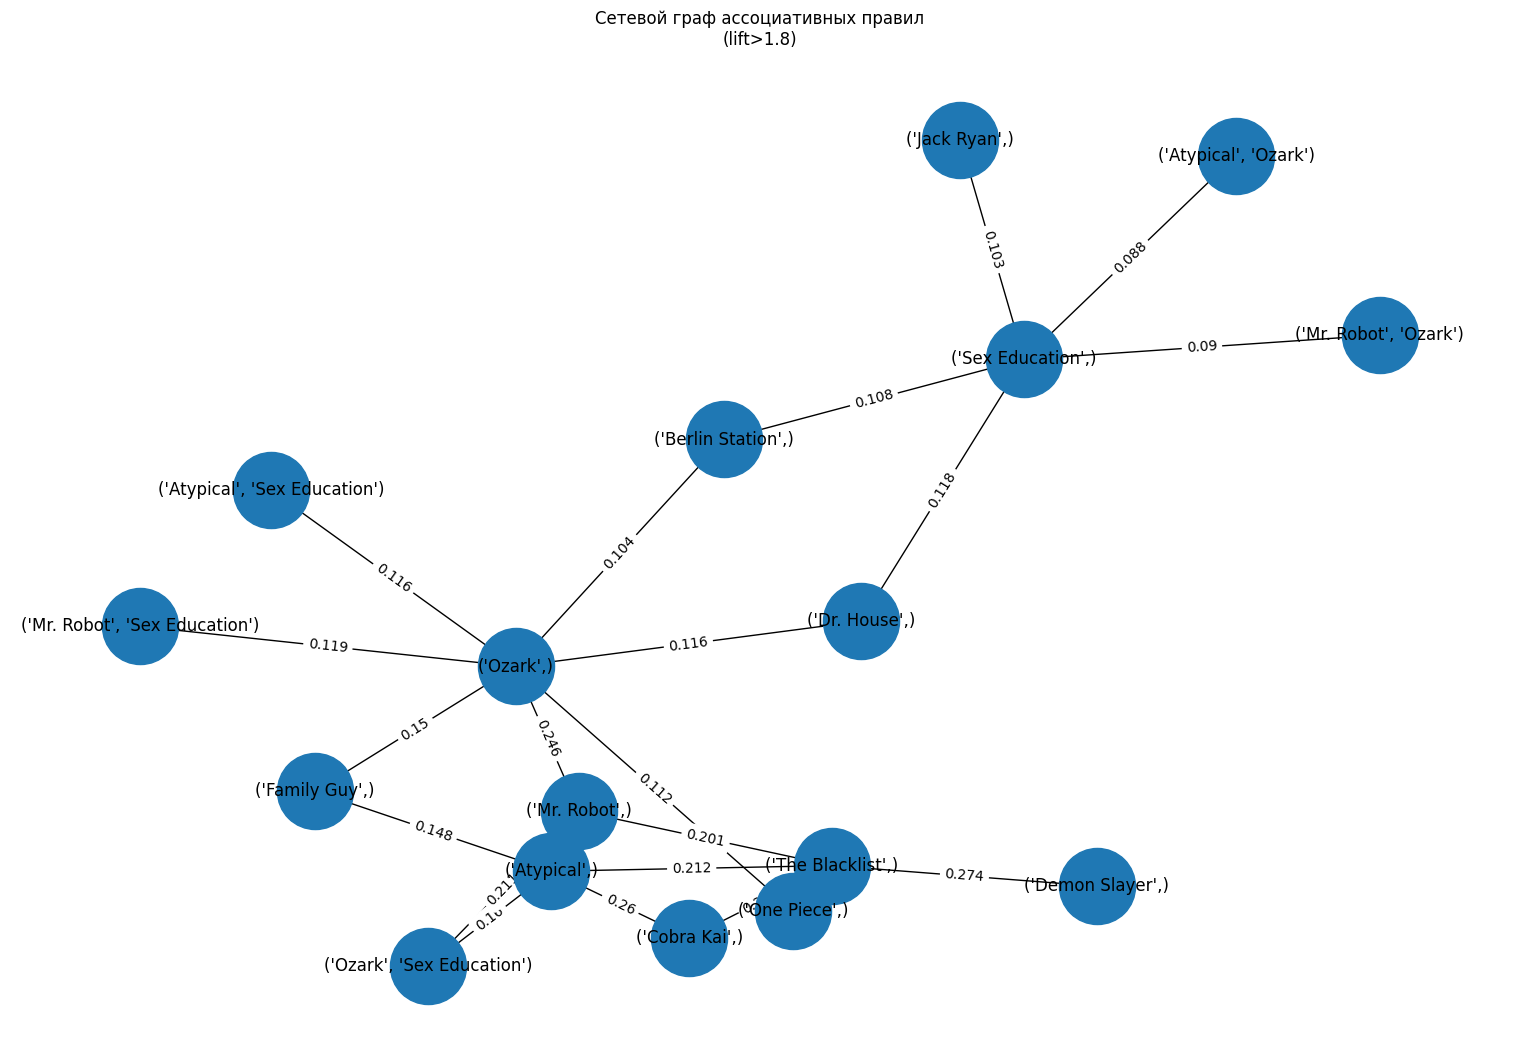

In [ ]:

G = nx.Graph()

for index, row in filtered_rules.iterrows():
    antecedent = tuple(row['antecedents'])  
    consequent = tuple(row['consequents'])
    G.add_node(antecedent)
    G.add_node(consequent)
    G.add_edge(antecedent, consequent, weight=round(row['confidence'],3))

plt.figure(figsize=(15, 10)) 

pos = nx.spring_layout(G, k=0.3) 
nx.draw(G, pos, with_labels=True, node_size=3000)

edge_labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Сетевой граф ассоциативных правил\n(lift>1.8)')
plt.show()


#### Выводы по правилам

* Support   
В среднем равен 0.0288, с диапазоном от 0.0201 до 0.0751.  
Большинство правил редкие, встречаются менее чем в 7.5% случаев.

* Confidence  
Среднее доверие составляет 0.2345, варьируется от 0.0799 до 0.5118.  
Это указывает на то, что большая часть правил имеет низкую предсказательную силу.

* Lift  
Средний lift равен 1.61, с диапазоном от 0.897 до 2.812.  
Большинство правил показывает положительную связь, но не сильную; верхние 25% правил имеют lift выше 1.85, что указывает на более значимую связь.

### Подберем свои параметры для получения 6 правил

In [209]:
frequent_itemsets = apriori(dataset, min_support=0.05, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules[rules['antecedents'].apply(lambda x: len(x)) > 0]
rules = rules[rules['consequents'].apply(lambda x: len(x)) > 0]

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
len(rules.sort_values("lift",ascending=False))

6

##### Тривиальные правила

In [210]:
rules[np.abs(rules['lift'] - 1) < 0.05]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length


##### Полезные правила

In [211]:
rules[rules['lift'] > 1.2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(Atypical),(Sex Education),0.139938,0.255624,0.056140,0.401180,1.569412,0.020369,1.243071,0.421852,1,1
1,(Sex Education),(Atypical),0.255624,0.139938,0.056140,0.219621,1.569412,0.020369,1.102107,0.487413,1,1
2,(Ozark),(Sex Education),0.193705,0.255624,0.075129,0.387853,1.517277,0.025613,1.216008,0.422828,1,1
3,(Sex Education),(Ozark),0.255624,0.193705,0.075129,0.293904,1.517277,0.025613,1.141906,0.458001,1,1
4,(Two and a half men),(Sex Education),0.183591,0.255624,0.056553,0.308038,1.205043,0.009623,1.075747,0.208417,1,1
5,(Sex Education),(Two and a half men),0.255624,0.183591,0.056553,0.221235,1.205043,0.009623,1.048338,0.228586,1,1


C:\Users\user\AppData\Local\Temp\ipykernel_2888\1857416397.py:10: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



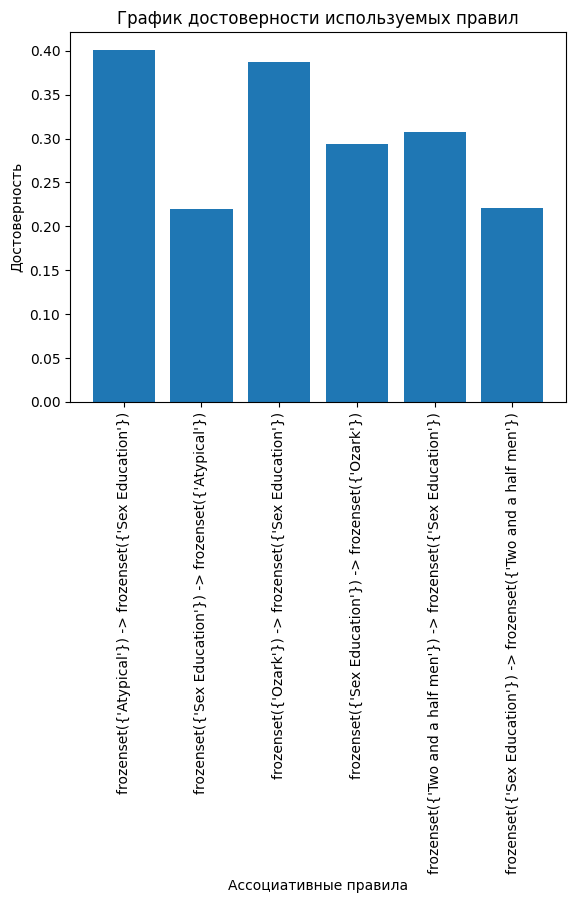

In [212]:

products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

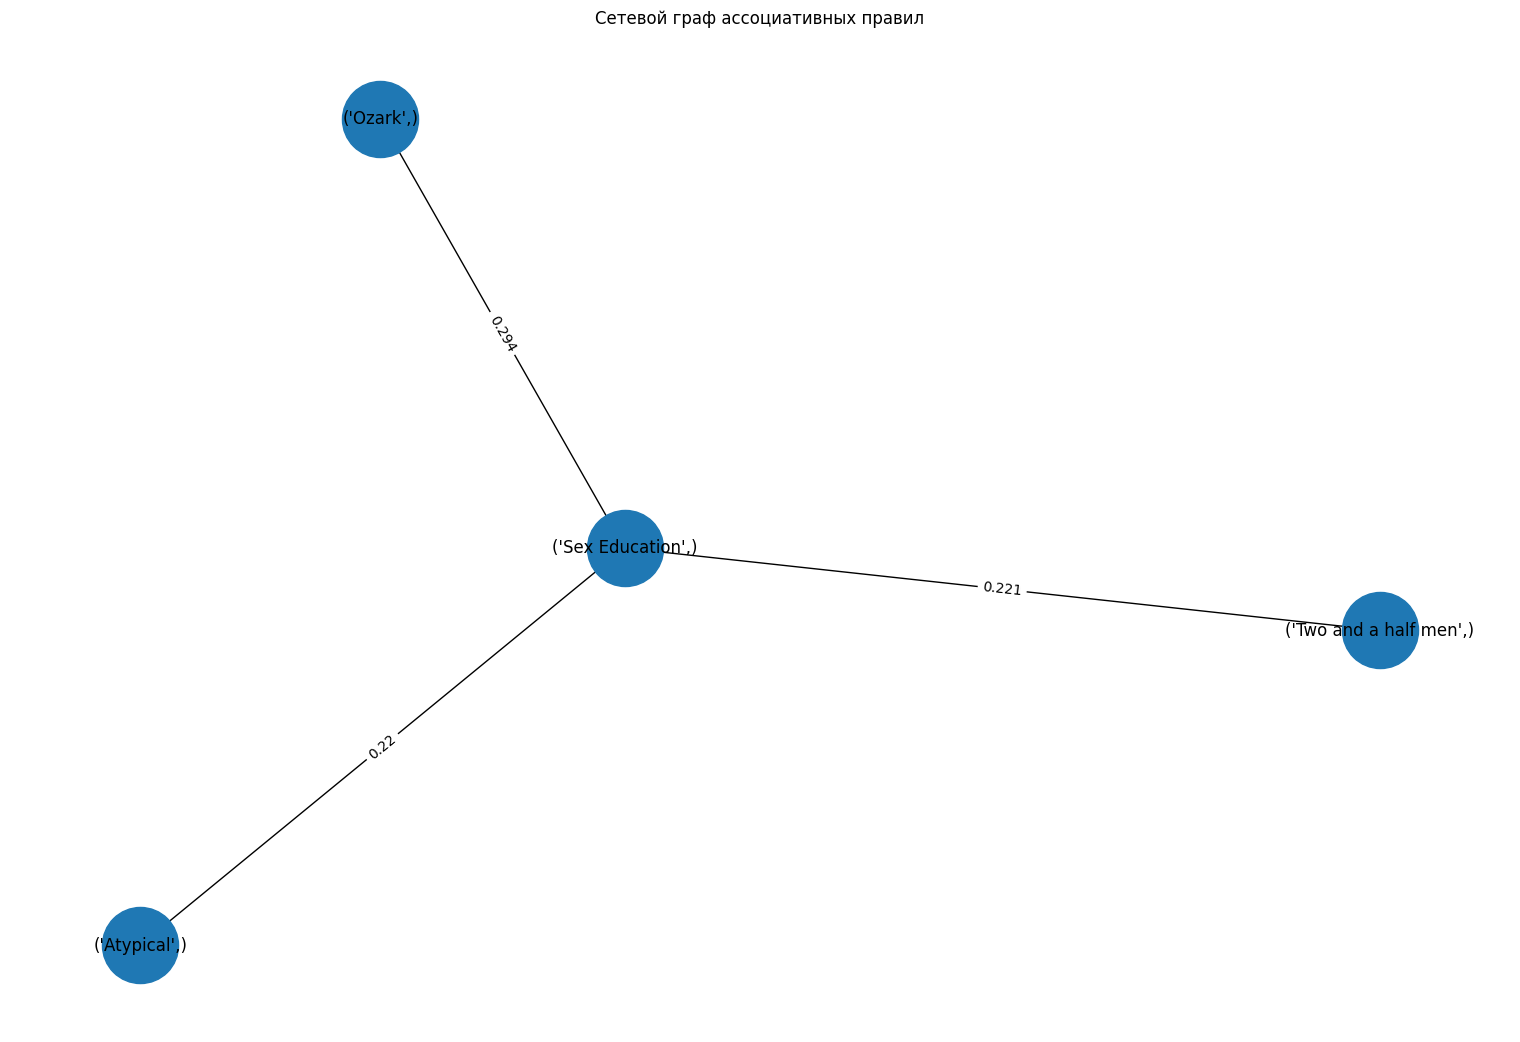

In [213]:

G = nx.Graph()

for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])  
    consequent = tuple(row['consequents'])
    G.add_node(antecedent)
    G.add_node(consequent)
    G.add_edge(antecedent, consequent, weight=round(row['confidence'],3))

plt.figure(figsize=(15, 10)) 

pos = nx.spring_layout(G, k=0.3) 
nx.draw(G, pos, with_labels=True, node_size=3000)

edge_labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Сетевой граф ассоциативных правил')
plt.show()


### Подберем для 4 правил

In [214]:
frequent_itemsets = apriori(dataset, min_support=0.0565, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules[rules['antecedents'].apply(lambda x: len(x)) > 0]
rules = rules[rules['consequents'].apply(lambda x: len(x)) > 0]

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
len(rules.sort_values("lift",ascending=False))

4

##### Тривиальные правила

In [215]:
rules[np.abs(rules['lift'] - 1) < 0.05]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length


##### Полезные правила

In [216]:
rules[rules['lift'] > 1.2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(Ozark),(Sex Education),0.193705,0.255624,0.075129,0.387853,1.517277,0.025613,1.216008,0.422828,1,1
1,(Sex Education),(Ozark),0.255624,0.193705,0.075129,0.293904,1.517277,0.025613,1.141906,0.458001,1,1
2,(Two and a half men),(Sex Education),0.183591,0.255624,0.056553,0.308038,1.205043,0.009623,1.075747,0.208417,1,1
3,(Sex Education),(Two and a half men),0.255624,0.183591,0.056553,0.221235,1.205043,0.009623,1.048338,0.228586,1,1


C:\Users\user\AppData\Local\Temp\ipykernel_2888\1857416397.py:10: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



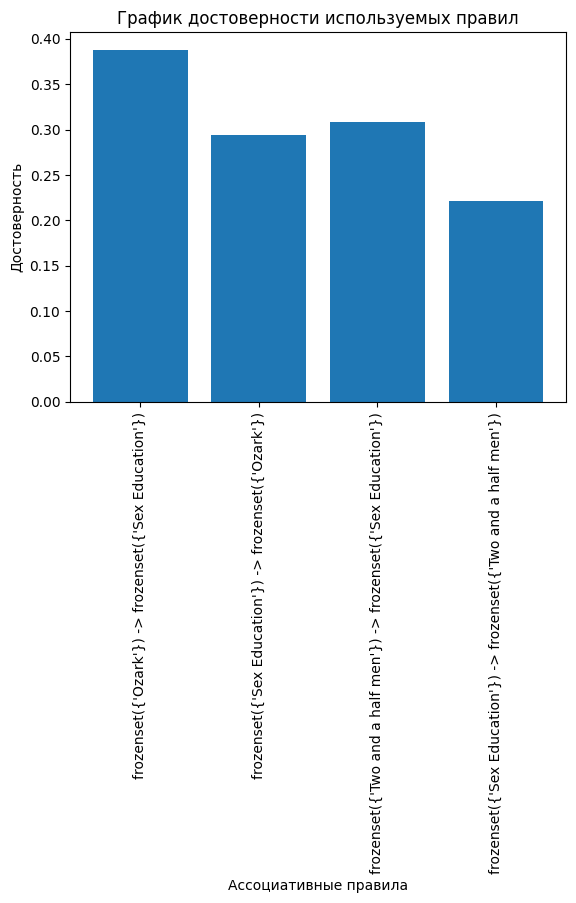

In [217]:

products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

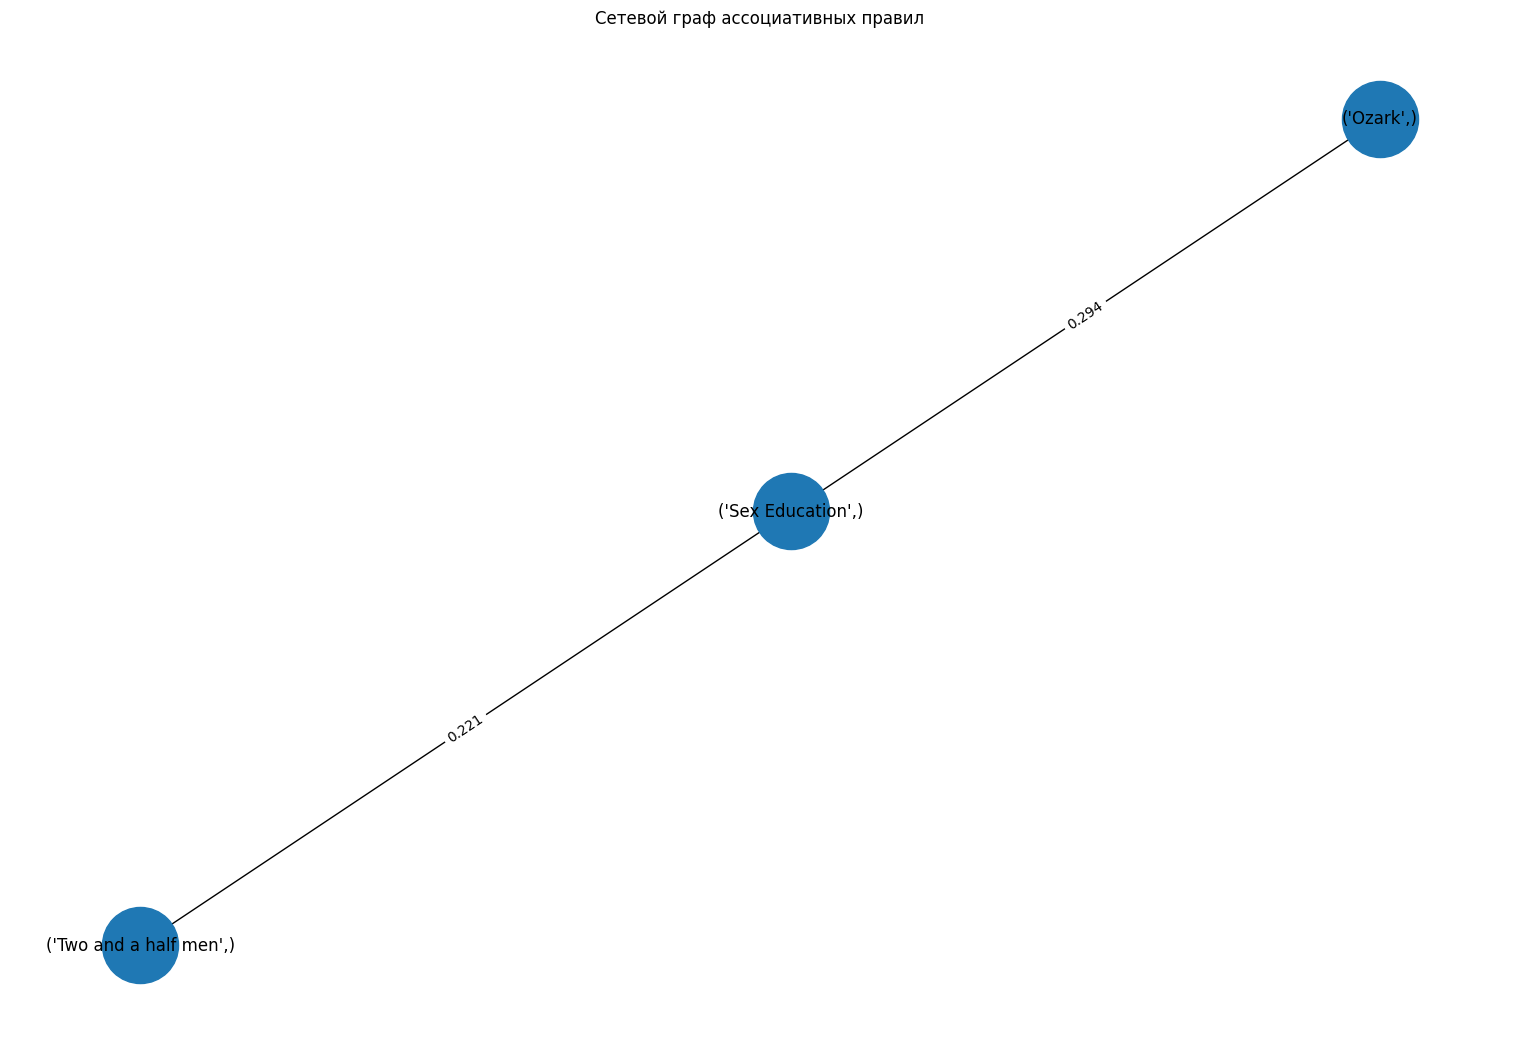

In [218]:

G = nx.Graph()

for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])  
    consequent = tuple(row['consequents'])
    G.add_node(antecedent)
    G.add_node(consequent)
    G.add_edge(antecedent, consequent, weight=round(row['confidence'],3))

plt.figure(figsize=(15, 10)) 

pos = nx.spring_layout(G, k=0.3) 
nx.draw(G, pos, with_labels=True, node_size=3000)

edge_labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Сетевой граф ассоциативных правил')
plt.show()


## Применение ассоциативных правил методом FPG

Это тот же алгоритм, что и Apriori, так что толку делать все тоже самое нет, можно просто убедиться, что результаты те же

In [ ]:
frequent_itemsets = fpgrowth(dataset, min_support=0.02, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.3)
rules = rules[rules['antecedents'].apply(lambda x: len(x)) > 0]
rules = rules[rules['consequents'].apply(lambda x: len(x)) > 0]

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
136,"(Ozark, Sex Education)",(Mr. Robot),0.075129,0.109391,0.023117,0.307692,2.812772,0.014898,1.286435,0.696831,2,1
137,(Mr. Robot),"(Ozark, Sex Education)",0.109391,0.075129,0.023117,0.211321,2.812772,0.014898,1.172683,0.723638,1,2
75,(Demon Slayer),(The Blacklist),0.075439,0.104850,0.020640,0.273598,2.609412,0.012730,1.232306,0.667097,1,1
74,(The Blacklist),(Demon Slayer),0.104850,0.075439,0.020640,0.196850,2.609412,0.012730,1.151170,0.689015,1,1
138,(Ozark),"(Mr. Robot, Sex Education)",0.193705,0.048916,0.023117,0.119339,2.439659,0.013641,1.079966,0.731874,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
112,(Outer Banks),(Ozark),0.175026,0.193705,0.033024,0.188679,0.974055,-0.000880,0.993806,-0.031277,1,1
105,(Sex Education),(Lucifer),0.255624,0.097936,0.024355,0.095277,0.972845,-0.000680,0.997060,-0.036143,1,1
104,(Lucifer),(Sex Education),0.097936,0.255624,0.024355,0.248683,0.972845,-0.000680,0.990761,-0.030015,1,1
114,(Outer Banks),(Sex Education),0.175026,0.255624,0.040144,0.229363,0.897267,-0.004596,0.965923,-0.121873,1,1


# Выводы

1. Метод ассоциативных правил позволяет выявлять взаимосвязи между элементами в больших наборах данных
2. В ходе экспериментов с изменением параметров (минимальная поддержка и достоверность) было замечено, что увеличение этих значений приводит к уменьшению общего количества извлеченных правил. Это подтверждает, что более строгие параметры отфильтровывают менее значимые ассоциации
3. Оценка значений метрик достоверности и лифта показала, что правила с высоким значением лифта (> 1) указывают на значительное усиление вероятности покупки одного товара при покупке другого
4. Сравнение алгоритмов Apriori и FPG продемонстрировало, что FPG более эффективен для больших наборов данных благодаря своей структуре FP-дерева, что позволяет избежать генерации большого количества кандидатов и снизить количество проходов по данным
